In [1]:
#######
# Starter code for Time Series Analysis and Forecasting
#
# You will need to install the YahooFinance Python api
#
# Using Anaconda environment:
# - conda install -c conda-forge yfinance
#
# Using pip 
# - pip install yfinance
#
# Veryify it is installed by importing it in your Jupyter Notebook.
# If you cannot get it to install, you can always Google Search
# "install yfinance Python library"  and it will give you search results
# that walk you through.   As of 13-Nov-2024 both methods work.
#
# https://stackoverflow.com/questions/39636128/yahoo-finance-package-installation-in-anaconda
###

In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.7/652.7 kB 8.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 21.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 11.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [4]:
import datetime 
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import numpy.linalg

import yfinance as yf
import pandas as pd

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler

from sktime.split import temporal_train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima 



ModuleNotFoundError: No module named 'sktime.split'

In [7]:
#####
# 40 years of data starting from when Disney got on the market
##
TRADE_START='1962-1-2'
TRADE_END='2002-1-2'

disneyTicker='DIS'

In [8]:
NUM_BINS= 20

In [9]:
disData= yf.download(disneyTicker, start=TRADE_START,end= TRADE_END)

[*********************100%%**********************]  1 of 1 completed


In [10]:
disData.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.092908,0.096026,0.092908,0.092908,0.057941,841958
1962-01-03,0.092908,0.094467,0.092908,0.094155,0.058719,801865
1962-01-04,0.094155,0.094467,0.093532,0.094155,0.058719,962238
1962-01-05,0.094155,0.094779,0.093844,0.094467,0.058914,962238
1962-01-08,0.094467,0.095714,0.092285,0.094155,0.058719,1282984


In [13]:
######
# To learn more, see multi-level columns in Pandas.
# They are kinda cool and make sense for complex aggregated data.
#
# https://pandas.pydata.org/docs/user_guide/advanced.html
#
# https://stackoverflow.com/questions/63107594/how-to-deal-with-multi-level-column-names-downloaded-with-yfinance
###
# df_dis_close = disData['Close'].DIS
df_dis_close = disData['Close']

In [14]:
df_dis_close.describe()

count    10069.000000
mean         7.280632
std         10.349134
min          0.053625
25%          0.745013
50%          1.292212
75%         10.810396
max         43.036064
Name: Close, dtype: float64

<AxesSubplot:>

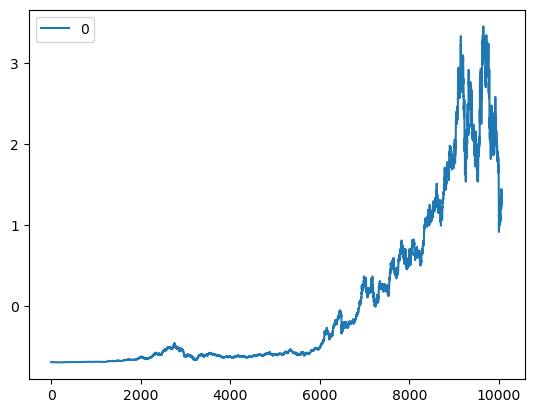

In [15]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_dis_close.values.reshape(-1, 1)) 
scaled_series= pd.DataFrame(scaled_data)
scaled_series.plot()

In [25]:
#####
#  Visualizations of various transformations
###

def visTransformations(df_data, dataName, windowSize):
    plt.figure(1,figsize=(30,90))
    plt.subplot(10,1,1)
    df_data.plot()
    plt.title(f'{dataName} closing price')
    
    plt.subplot(10,1,2)
    plt.title(f'{dataName} filtered outliers')
    z_scores = zscore(df_data)
    abs_z_scores = np.abs(z_scores)
    filtered_data = (abs_z_scores < 2)  # Z-score trheshold two standard deviations
    series_no_outliers = df_data[filtered_data]
    series_no_outliers.plot()

#    plt.subplot(9,1,3)
#    plt.title('{dataName} scaled and filtered')
#    scaler = StandardScaler()
#    scaled_data = scaler.fit_transform(series_no_outliers.values.reshape(-1, 1)) 
#    scaled_series= pd.DataFrame(scaled_data)
#    scaled_series.plot()

    plt.subplot(10,1,3)
    binCountsDIS, binEdgesDIS, patchesDIS= plt.hist(df_data,NUM_BINS)
    plt.title(f'{dataName} stock distribution')
    
    # long vs short term trend depends on window size
    plt.subplot(10,1,4)
    plt.title(f'{dataName} rolling average win=%i' %windowSize )
    df_dis_close.rolling(windowSize).mean().plot()
    
    # std dev over rolling window
    # shows how variance changes over time
    plt.subplot(10,1,5)
    plt.title(f'{dataName} rolling std win=%i'%windowSize)
    df_data.rolling(windowSize).std().plot()
    
    # can think of it like the local slope
    plt.subplot(10,1,6)
    plt.title(f'{dataName} difference 1x')
    df_data.diff().plot()

    DIFF_ORDER= 10
    plt.subplot(10,1,7)
    plt.title(f'{dataName} difference {DIFF_ORDER}x')
    df_diff= df_data
    for i in range(DIFF_ORDER):
        df_diff= df_diff.diff()
        
    df_diff.plot()

    # computes rolling window mean over difference
    # can i really remove the trend?
    plt.subplot(10,1,8)
    plt.title(f'{dataName} mean diff win=%i' %windowSize)
    df_data.diff().rolling(windowSize).mean().plot()
    
    plt.subplot(10,1,9)
    plt.title(f'{dataName} std diff win=%i' %windowSize)
    df_data.diff().rolling(windowSize).std().plot()

    # standard scaler 
    plt.subplot(10,1,10)
    plt.title(f'{dataName} scaled and filtered')
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(series_no_outliers.values.reshape(-1, 1)) 
    plt.plot(scaled_data)

In [66]:
##############
# Augmented Dickey-Fuller Test
#
# Ho: It is non-stationary
# H1: It is stationary
#
#####

def adfuller_test(sales):
    result=adfuller(sales)
    print(result)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

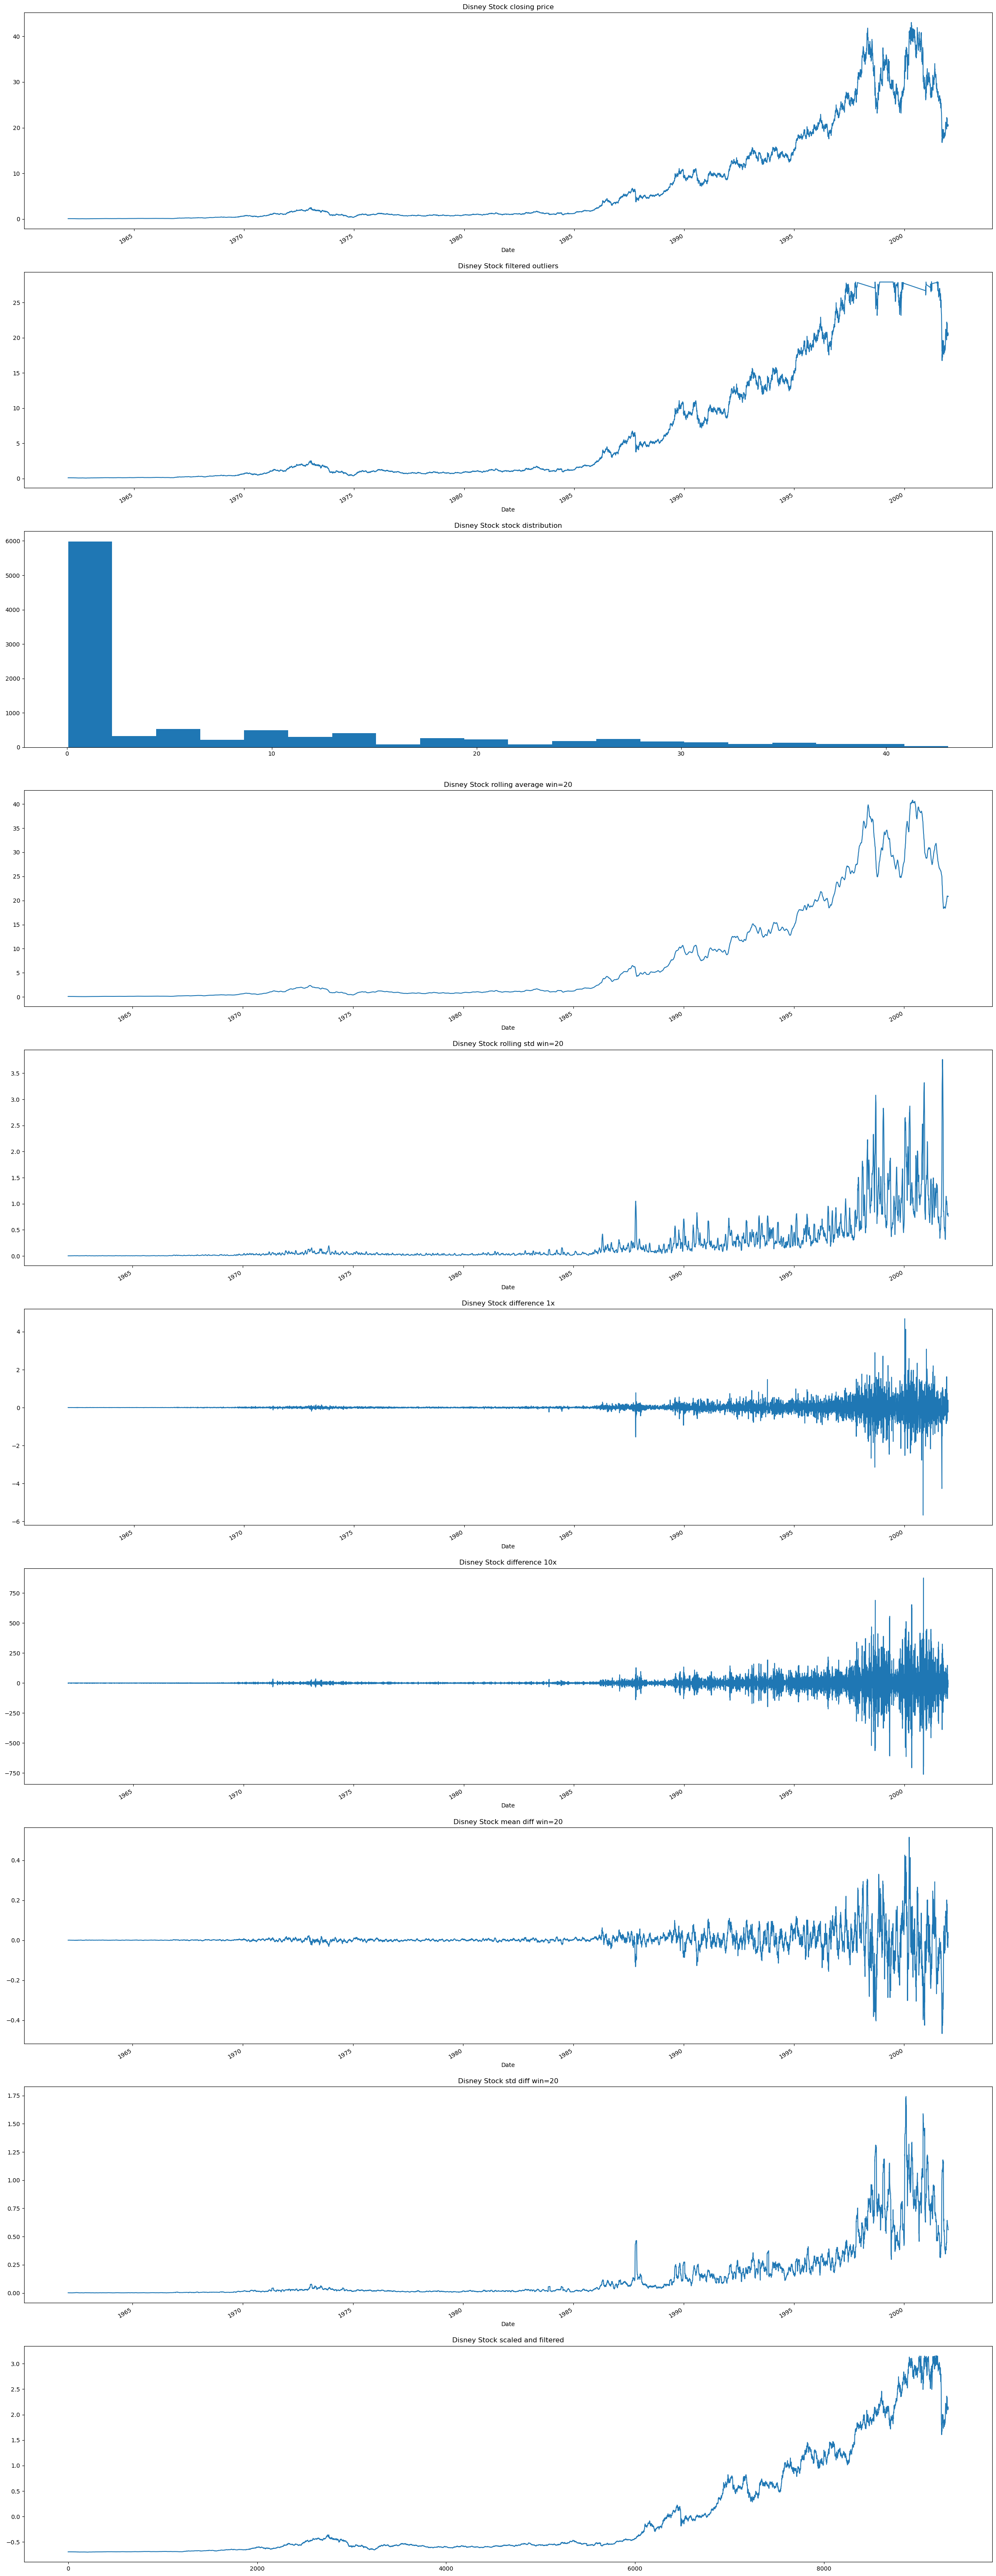

In [27]:
visTransformations(df_dis_close,'Disney Stock',20)

In [34]:
# def visTransformationsEWMA(df_data, dataName, windowSize):
#    plt.subplot(1, 1, 1)
#    plt.title(f'{dataName} exponential weighted moving average')
#    df_dis_close.ewm(windowSize).mean().plot()

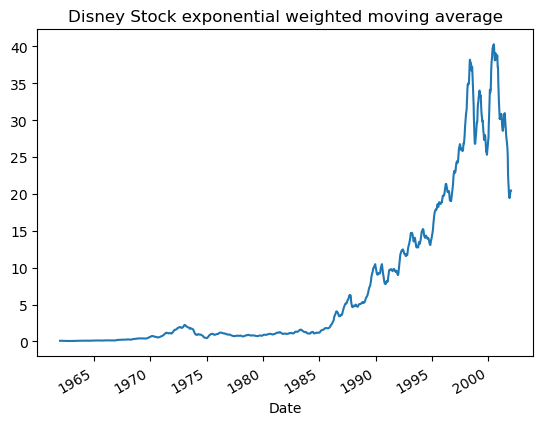

In [37]:
# visTransformationsEWMA(df_dis_close,'Disney Stock',20)

In [64]:
def vis(df_data, dataName, windowSize):
    plt.figure(1,figsize=(30,40))
    
    plt.subplot(4, 1, 1)
    df_data.plot()
    plt.title(f'{dataName} closing price')
    
    plt.subplot(4, 1, 2)
    plt.title(f'{dataName} simple moving average')
    df_dis_close.rolling(windowSize).mean().plot()
    
    plt.subplot(4, 1, 3)
    plt.title(f'{dataName} exponential weighted moving average')
    df_dis_close.ewm(windowSize).mean().plot()
    
    plt.subplot(4, 1, 4)
    plt.title(f'{dataName} closing price and averages compared')
    df_data.plot()
    df_dis_close.rolling(windowSize).mean().plot()  
    df_dis_close.ewm(windowSize).mean().plot()

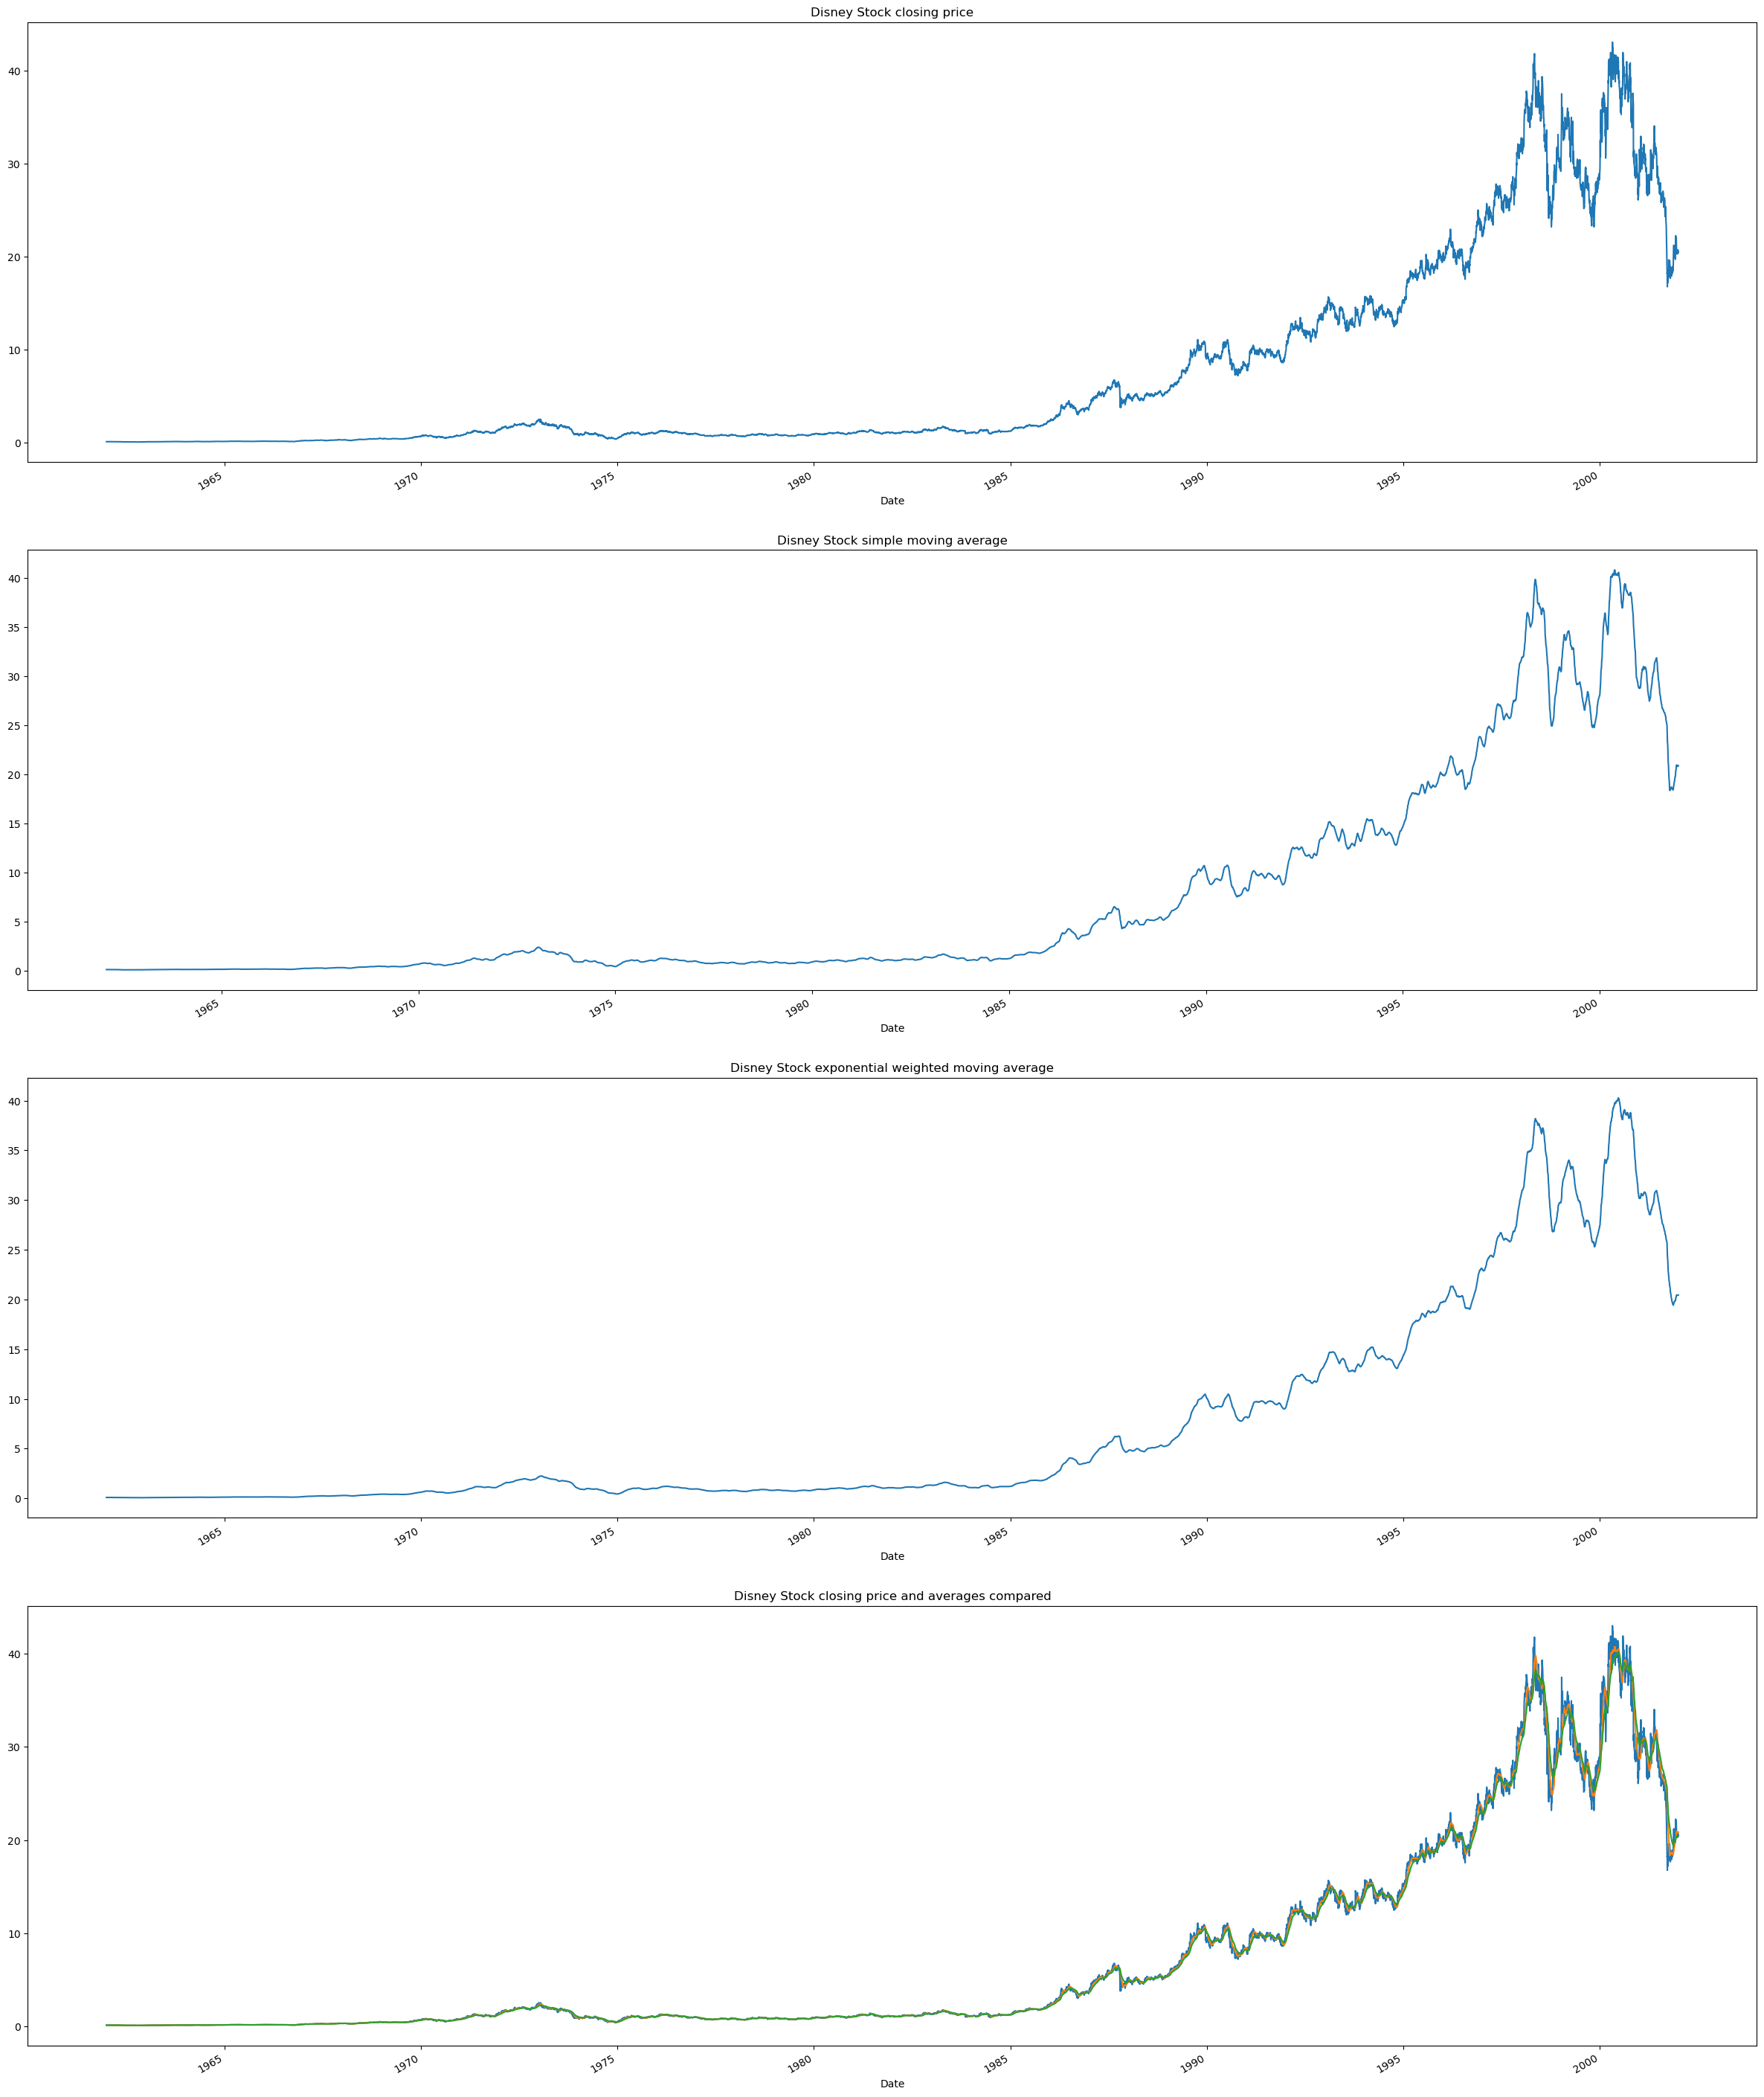

In [65]:
vis(df_dis_close,'Disney Stock',20)

In [59]:
# visTransformations(df_nvidia_close,'NVIDIA Stock',20)

In [54]:
df_dis_close.size

10069

NameError: name 'plot_acf' is not defined

<Figure size 3000x1000 with 0 Axes>

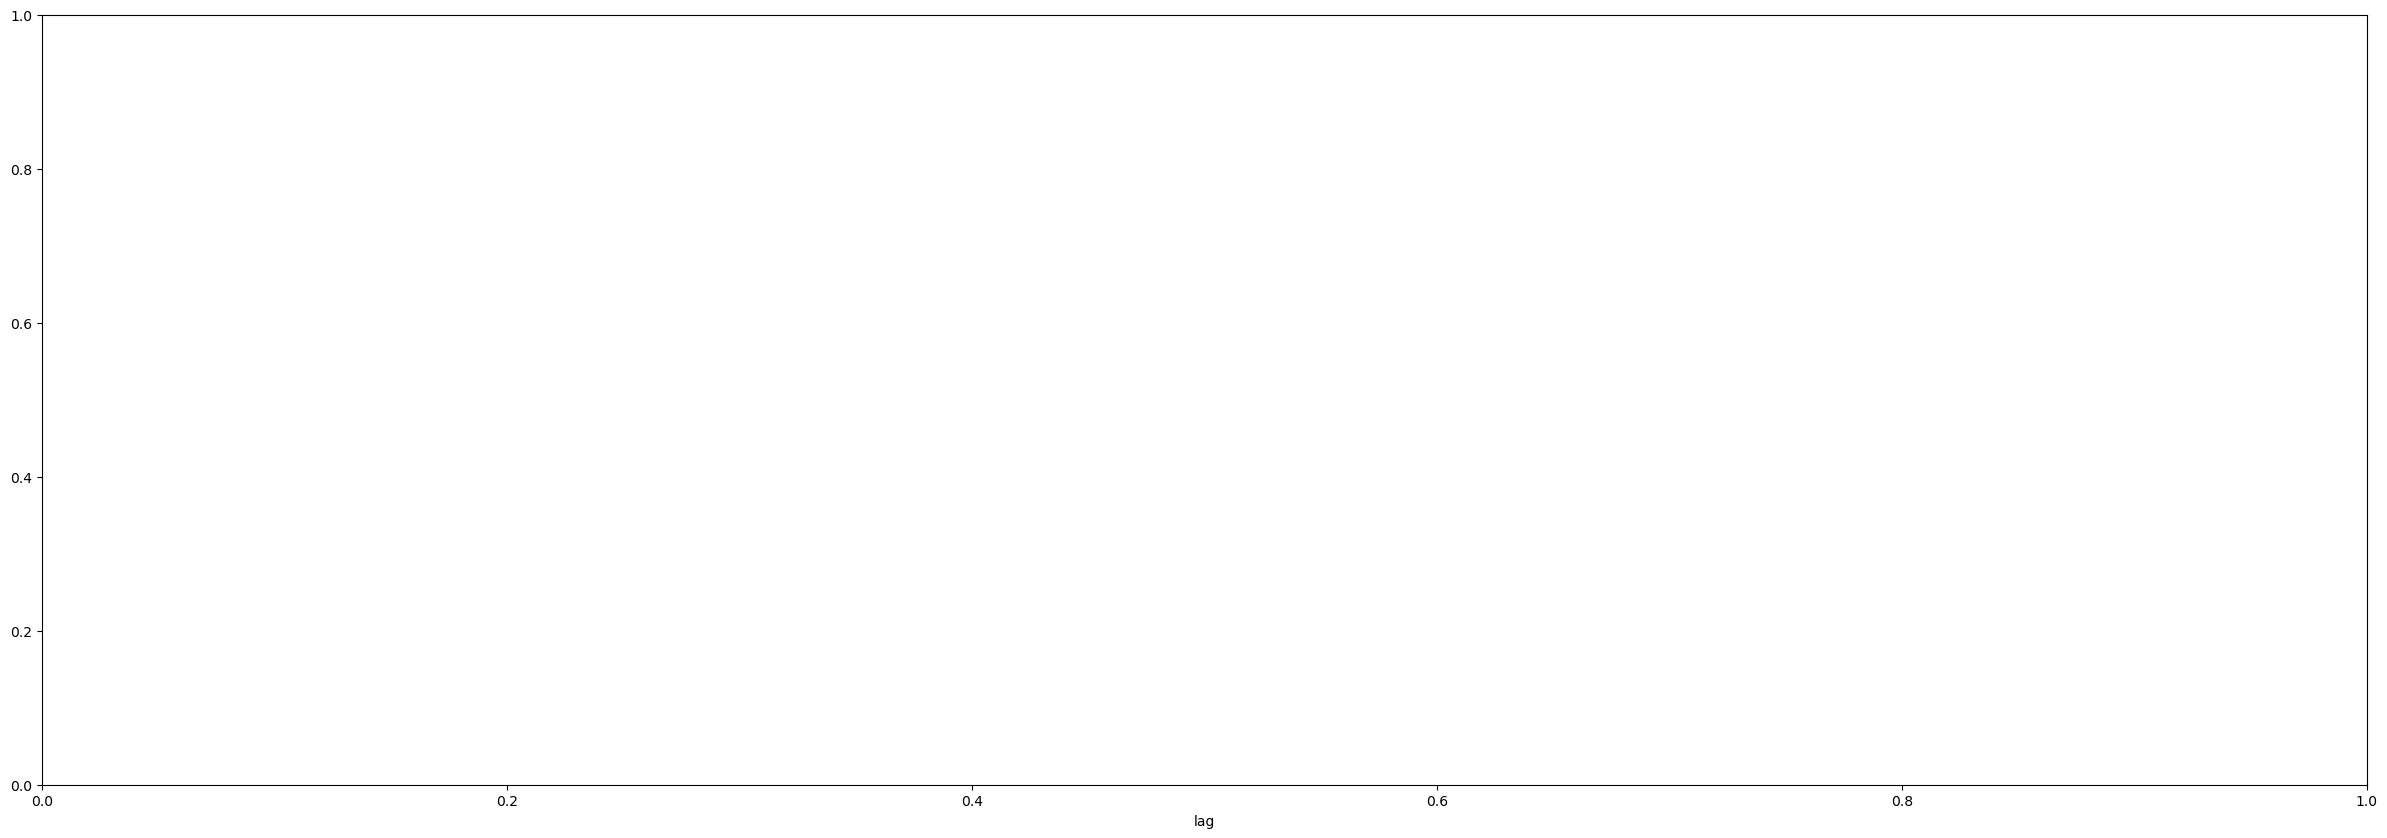

In [55]:
plt.figure(3,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_dis_close, lags=100, title='DIS Autocorrelation',alpha=0.05,ax=ax);

NameError: name 'plot_pacf' is not defined

<Figure size 3000x1000 with 0 Axes>

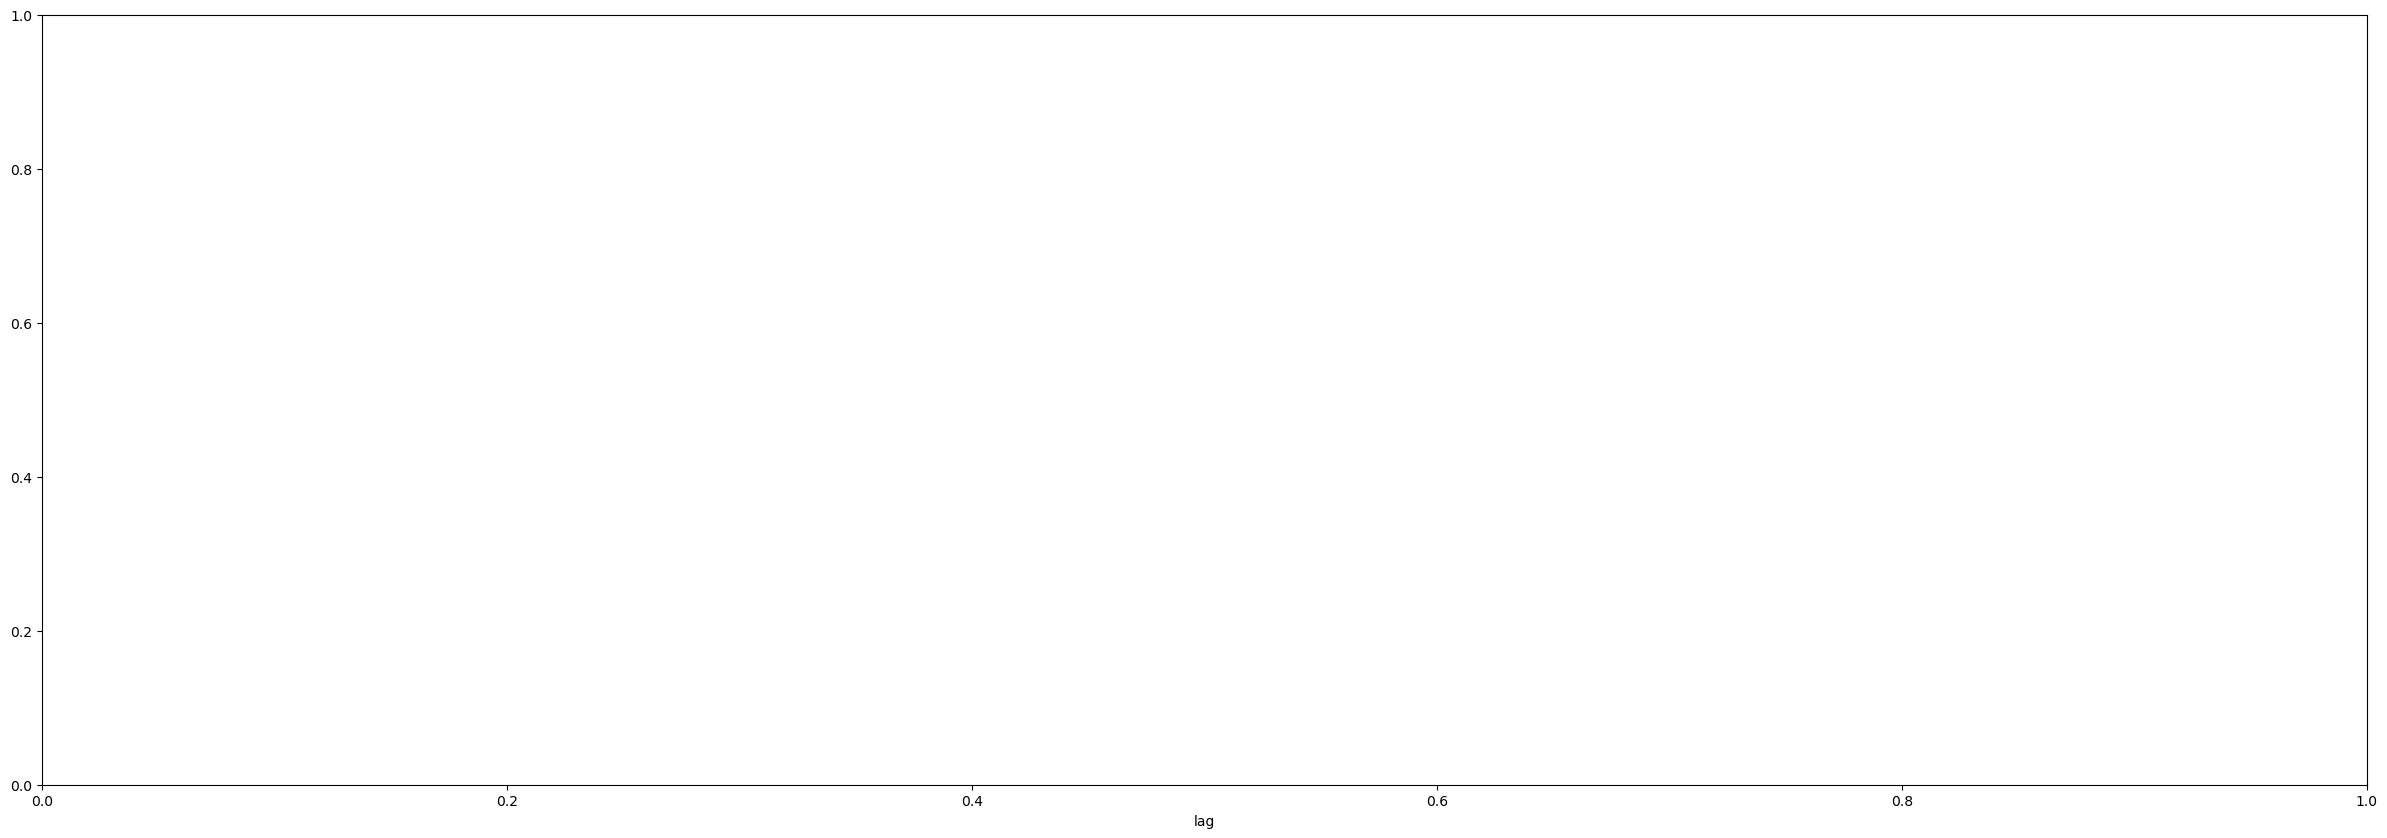

In [56]:
plt.figure(4,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_dis_close, lags=5, title='DIS Partial Autocorrelation',alpha=0.05,ax=ax);

In [57]:
DAYS_PER_QUARTER= 63
result= seasonal_decompose(df_dis_close,model='multiplicative',period=DAYS_PER_QUARTER)
o= result.plot()

NameError: name 'seasonal_decompose' is not defined

In [68]:
####
# Run the augmented Dickey-Fuller Test
###
adfuller_test(df_dis_close)

NameError: name 'adfuller' is not defined

In [34]:
#######
#  Tools are in place in Python to experiment with ARIMA and
#  propose the parameters (p,d,q)
####

DO_IT= False

if (DO_IT):
    stepwise_fit = auto_arima(df_dis_close, start_p = 1, start_q = 1, 
                              max_p = 3, max_q = 3, m = 12, 
                              start_P = 0, seasonal = True, 
                              d = None, D = 1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwis

    stepwise_fit.summary()

In [ ]:
####### 
#  Fit the SARIMAX model
#
#  SARIMAX( nonseasonal, seasonal)
#
#  nonseasonaly= (p,d,q)
#
#  p: regression window size
#  d: differencing order
#  q: moving average (prediction error window)
#
#  seasonal=  (P,D,Q, m)
#
#  P: regression window size
#  D: differencing order
#  Q: moving average (prediction error window)
#
###

model = SARIMAX(df_dis_close,  
                order = (2,1,1),  
                seasonal_order =(4, 1, 1, 20)) 
  
result = model.fit() 
result.summary() 

C:\Users\Audrey\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Audrey\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
df_dis_close.size

In [ ]:
#######
# New index from Date Time
#
# Utility routine to fix issue with yfinance DateTime index
###
def computeDateList(startDate, numDays):
    dateList = []
    for x in range (0, numDays):
        dt= startDate + datetime.timedelta(days= x)
    
        dateList.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
        
    return dateList

In [ ]:
origStartDate= datetime.datetime(2019,12,4)

forecastStartDate= datetime.datetime(2024,12,5)

HIST_DAYS= df_dis_close.size

NUM_DAYS= 252

disDateIndex= computeDateList(origStartDate,HIST_DAYS)

forecastDateIndex= computeDateList(forecastStartDate, NUM_DAYS)


In [ ]:
#######
# Use SARIMA model to do the forecast
# 
# Tinker with Series objects to properly set the index to good datetime format
####

ONE_QUARTER= 63 * 1
TWO_QUARTER= 63 * 2
THREE_QUARTER= 63 *3
FOUR_QUARTER= 64* 4

forecastHorizon= FOUR_QUARTER

####
# do the forecast over time horizon (future days)
##
forecast= result.forecast(steps=forecastHorizon)

#myForecast= pd.Series(forecast.values, index=forecastDateIndex)

####
# do prediction over existing time series
##
predictions= result.predict()

####
# set Series index to proper datetime formatted strings
##
myPredictions= pd.Series(predictions.values, index= disDateIndex)

myDISClose= pd.Series(df_dis_close.values, index= disDateIndex)

####
# Visualize
###
plt.figure(12,figsize=(20,15))
plt.subplot(2,1,1)
myDISClose.plot(color='blue',label='actual')
myPredictions.plot(color='red',label='predictions')
forecast.plot(color='green',label='forecast')
plt.legend()
plt.title(f'SARIMA forecast horizon= {forecastHorizon} steps')

In [ ]:
plt.figure(5,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_acf(df_dis_close, lags=100, title='DIS Autocorrelation',alpha=0.05,ax=ax);

In [ ]:
plt.figure(6,figsize=(30,10))
fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel('lag')
pltOutput= plot_pacf(df_dis_close, lags=5, title='DIS Partial Autocorrelation',alpha=0.05,ax=ax);

In [69]:
######
# Break time-series into it's constituent parts
#
# - level
# - trend
# - seasonality
# - noise
#
#  x(t) = Level + Trend + Seasonality + Noise
##
DAYS_PER_QUARTER= 63
result= seasonal_decompose(df_dis_close,model='multiplicative',period=DAYS_PER_QUARTER)
o= result.plot()

NameError: name 'seasonal_decompose' is not defined

In [ ]:
test_result=adfuller_test(df_dis_close)
test_result